In [1]:
from stackelberg_model import *
import matplotlib.pyplot as plt
from itertools import permutations

### Solve Monotonic

In [2]:
# Constraints
n = 15
k = 5
constraints = [(0,k-1)] + (k-1)*[(0,k)] + [(1,k+1)] + (n-k-1)*[(k+1,n-1)]

p_star, v_star, tight_constraints = solve_monotonic_01(n, k, constraints, verbose=False, lex_order_p=-1)
print("p_star:", np.round(p_star, 3))
print("v_star:", np.round(v_star, 3))

p_star: [1.  0.8 0.8 0.8 0.8 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
v_star: 4.2


In [14]:
# Constraints
n = 15
k = 5
constraints = [(0,k-1), (0, k+2), (0, k+3), (0, k+4), (1, k+4), (1, k+5), (6, k+6), (7, k+7), (8, k+8), (9, k+9), (10, k+10), (11, k+11), (12, k+12), (13, k+13), (14, k+14)]

p_star, v_star, tight_constraints = solve_monotonic_01(n, k, constraints, verbose=False, lex_order_p=-1)
print("p_star:", np.round(p_star, 3))
print("v_star:", np.round(v_star, 3))

p_star: [1.    0.444 0.444 0.444 0.444 0.444 0.444 0.444 0.444 0.444 0.    0.
 0.    0.    0.   ]
v_star: 2.778


In [ ]:
# Constraints
n = 10
k = 3
constraints = [(0,k-1), (0, k+1), (0, k+3)]

p_star, v_star, tight_constraints = solve_monotonic_01(n, k, constraints, verbose=False, lex_order_p=1)
print("p_star:", np.round(p_star, 3))
print("v_star:", np.round(v_star, 3))

p_star: [1.  0.8 0.4 0.4 0.4 0.  0.  0.  0.  0. ]
v_star: 1.8


In [3]:
# Constraints
n = 10
k = 2
constraints = [(0, k+1), (0, k+3)]

p_star, v_star, tight_constraints = solve_monotonic_01(n, k, constraints, verbose=False, lex_order_p=1)
print("p_star:", np.round(p_star, 3))
print("v_star:", np.round(v_star, 3))

p_star: [0.8 0.4 0.4 0.4 0.  0.  0.  0.  0.  0. ]
v_star: 0.8


In [4]:
# Constraints
n = 10
k = 2
constraints = [(0, k+1), (0, k+3)]

p_star, v_star, tight_constraints = solve_monotonic_01(n, k, constraints, verbose=False, lex_order_p=-1)
print("p_star:", np.round(p_star, 3))
print("v_star:", np.round(v_star, 3))

p_star: [0.8 0.4 0.4 0.4 0.  0.  0.  0.  0.  0. ]
v_star: 0.8


### Solve Non-Monotonic

In [17]:
def generate_instance(n):
    # generate n random intervals
    intervals = []
    for _ in range(n):
        a = np.round(10*np.random.rand(), 2)
        b = np.round(10*np.random.rand(), 2)
        if a > b:
            a, b = b, a
        intervals.append((a,b))
    return intervals

def get_constraints(intervals):
    n = len(intervals)
    # tuples where LCB_i > UCB_j => i < j
    constraints = [(i,j) for i in range(n) for j in range(n) if intervals[i][0] > intervals[j][1]]
    return constraints

def prune_instance(intervals, k):
    n = len(intervals)
    constraints = get_constraints(intervals)
    A = [0]*len(intervals)
    B = [0]*len(intervals)
    for c in constraints:
        A[c[0]] += 1 # num intevals that i is strictly above 
        B[c[1]] += 1 # num intevals that i is strictly below
    # if A[i] >= n-k, then i must be in the top k
    top = [i for i in range(n) if A[i] >= n-k]
    # if B[i] >= k, then i is never in the top k
    bottom = [i for i in range(n) if B[i] >= k]
    # remove top and bottom from intervals'
    top_intervals = [intervals[i] for i in top]
    bottom_intervals = [intervals[i] for i in bottom]
    intervals = [intervals[i] for i in range(n) if i not in top+bottom]
    k = k - len(top)
    return intervals, k, top_intervals, bottom_intervals

def sort_instance(intervals, k=None, by='A'):
    n = len(intervals)
    constraints = get_constraints(intervals)
    A = [0]*len(intervals)
    B = [0]*len(intervals)
    for c in constraints:
        A[c[0]] += 1 # num intevals that i is strictly above 
        B[c[1]] += 1 # num intevals that i is strictly below
    if by == 'A':
        # sort 1 to n by decreasing A breaking ties with increasing B
        sorted_indices = sorted(range(n), key=lambda i: (-A[i], B[i]))
        order = sorted_indices
    elif by == 'B':
        # sort 1 to n by decreasing B breaking ties with increasing A
        sorted_indices = sorted(range(n), key=lambda i: (B[i], -A[i]))
        order = sorted_indices
    elif by == 'A+B':
        # sort 1 to n by decreasing A breaking ties with increasing B
        sorted_indices = sorted(range(n), key=lambda i: (-A[i], B[i]))
        top = sorted_indices[:k]
        bottom = sorted_indices[k:]
        # sort bottom_k by increasing B breaking ties with decreasing A
        bottom = sorted(bottom, key=lambda i: (B[i], -A[i]))
        order = top + bottom
    return [intervals[i] for i in order]


def solve_instance(intervals, k, lex_order_p=0, force_monotone=False, order_by='A'):
    intervals_pruned, k_pruned, top, bottom = prune_instance(intervals, k)
    # (1) prune all intervals that are always in the top k or never in the top k
    if k_pruned == 0:
        return k, [1]*k + [0]*(n-k), None
    n_pruned = len(intervals_pruned)
    # (2) solve the pruned instance
    # generate all permutations of 0 to (n-1) such that LCB_i > UCB_j => i < j
    intervals_pruned = sort_instance(intervals_pruned, k=k_pruned, by=order_by)
    constraints = get_constraints(intervals_pruned) # get all constraints on sigma
    perms = list(permutations(range(n_pruned)))
    perms = [p for p in perms if all((p[i] < p[j]) for i,j in constraints)]
    thetas = [1]*k_pruned + [0]*(n_pruned-k_pruned)    # theta is top-k 
    # solve optimization problem
    v_star, p_star, _ = get_optimal_strategy(thetas, k_pruned, perms, verbose=False, monotone_p=force_monotone,
                                              lex_order_p=lex_order_p, return_tight_constraints=False)
    # (3) add top and bottom intervals to the solution
    v_star += len(top)
    p_star = len(top)*[1] + list(p_star) + len(bottom)*[0]
    sorted_intervals = top + intervals_pruned + bottom
    return v_star, p_star, sorted_intervals

def plot_intervals(intervals):
    n = len(intervals)
    _, ax = plt.subplots()
    for i, (a,b) in enumerate(intervals):
        ax.plot([i,i], [a,b], 'k-')
    # smart x ticks so that not too crowded
    if n > 10:
        step = max(1, n // 10)
        # round step to closest multiple of 5
        step = 5 * max(round(step/5), 1)
        ax.set_xticks(range(0, n, step))
        ax.set_xticklabels([f'{i}' for i in range(0, n, step)])
    else:
        ax.set_xticks(range(n))
        ax.set_xticklabels([f'{i}' for i in range(n)])

    ax.set_xlabel('Interval')
    ax.set_ylabel('Value')

    plt.vlines(k+0.5, 0, 10, linestyles='dashed', colors='red', alpha=0.5)

    plt.show()

In [ ]:
n = 12
iters = 1000
for k in range(4,6):
    for _ in range(iters):
        intervals = generate_instance(n)
        v_star, p_star, _ = solve_instance(intervals, k, lex_order_p=1, order_by='A', force_monotone=False)
        p_check = np.round(p_star, 3)
        if all(p_check[i] >= p_check[i+1] for i in range(n-1)):
            continue
        v_star1, p_star1, _ = solve_instance(intervals, k, lex_order_p=0, order_by='B', force_monotone=True)
        if np.isclose(v_star, v_star1):
            continue
        v_star2, p_star2, _ = solve_instance(intervals, k, lex_order_p=0, order_by='A', force_monotone=True)
        if np.isclose(v_star, v_star2):
            continue
        
        # monotonic not optimal
        print("k:", k)
        intervals = sort_instance(intervals, k)
        print("intervals:", intervals)
        print("constraints:", get_constraints(intervals))
        print("p_star:", np.round(p_star, 3))
        break
    print('DONE with k:', k)

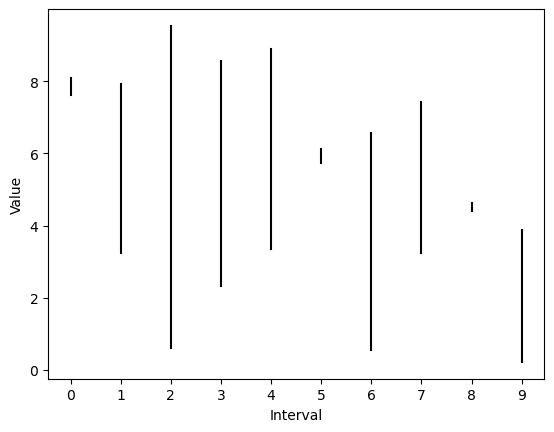

p_star: [1.    0.455 0.182 0.455 0.455 0.455 0.455 0.182 0.182 0.182]
v_star: 1.818
constraints: [(0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (5, 8), (5, 9), (8, 9)]


In [21]:
intervals = [(7.61, 8.08), (5.74, 6.12), (4.4, 4.63), (3.25, 7.91), (0.61, 9.53), (2.31, 8.56), (3.35, 8.9), (0.56, 6.56), (3.25, 7.42), (0.22, 3.87)]
k = 4

intervals, k, _, _ = prune_instance(intervals, k)
intervals = sort_instance(intervals, by='B', k=k)
constraints = get_constraints(intervals)
plot_intervals(intervals)

v_star, p_star, _ = solve_instance(intervals, k, lex_order_p=-1)
print("p_star:", np.round(p_star, 3))
print("v_star:", np.round(v_star, 3))

print("constraints:", get_constraints(intervals))


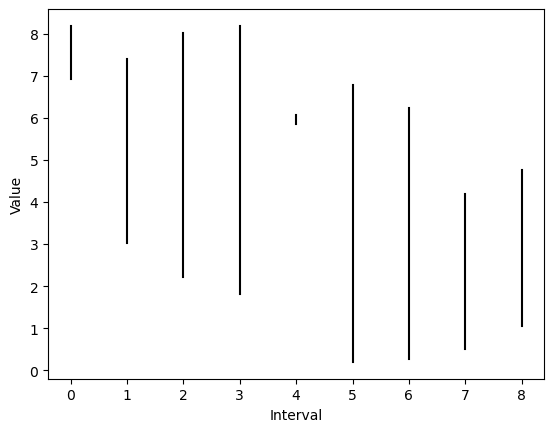

intervals: [(6.92, 8.18), (3.03, 7.4), (2.22, 8.02), (1.81, 8.17), (5.85, 6.06), (0.2, 6.77), (0.27, 6.24), (0.51, 4.18), (1.05, 4.77)]
constraints: [(0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (4, 7), (4, 8)]
p_star: [1.    0.52  0.434 0.379 0.333 0.207 0.126 0.    0.   ]
v_star: 1.3333333333282031


In [23]:
intervals = [(6.92, 8.18), (5.85, 6.06), (3.03, 7.4), (2.22, 8.02), (1.81, 8.17), (0.2, 6.77), (0.27, 6.24), (0.51, 4.18), (1.05, 4.77), (0.09, 1.98)]
k = 3
intervals, k, _, _ = prune_instance(intervals, k)
intervals = sort_instance(intervals, k, by='B')

plot_intervals(intervals)
print("intervals:", intervals)
print("constraints:", get_constraints(intervals))
v_star, p_star, _ = solve_instance(intervals, k, lex_order_p=0, force_monotone=True, order_by='B')
print("p_star:", np.round(p_star, 3))
print("v_star:", v_star)

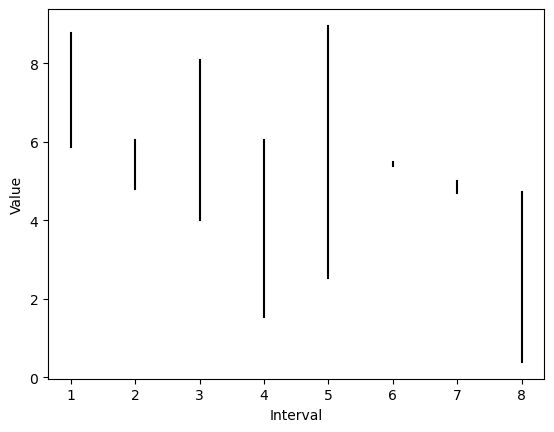

[(1, 6), (1, 7), (1, 8), (2, 8), (6, 7), (6, 8)]


In [111]:
intervals = [(5.86, 8.77),
  (4.79, 6.04),
  (4.01, 8.09),
  (1.54, 6.05),
  (2.52, 8.95),
  (5.38, 5.49),
  (4.7, 5.0),
  (0.39, 4.72)]
intervals = sort_instance(intervals, k)
plot_intervals(intervals)
print([(i+1, j+1) for i,j in get_constraints(intervals)])

In [112]:
solve_instance(intervals, k, lex_order_p=0)

(array(2.28571429),
 [0.8597649581861538,
  0.5714285714663618,
  0.5714285714098927,
  0.5714285714098927,
  0.5714285714098927,
  0.8545207560757458,
  4.270556163275274e-11,
  0.0],
 [(5.86, 8.77),
  (4.79, 6.04),
  (4.01, 8.09),
  (1.54, 6.05),
  (2.52, 8.95),
  (5.38, 5.49),
  (4.7, 5.0),
  (0.39, 4.72)])

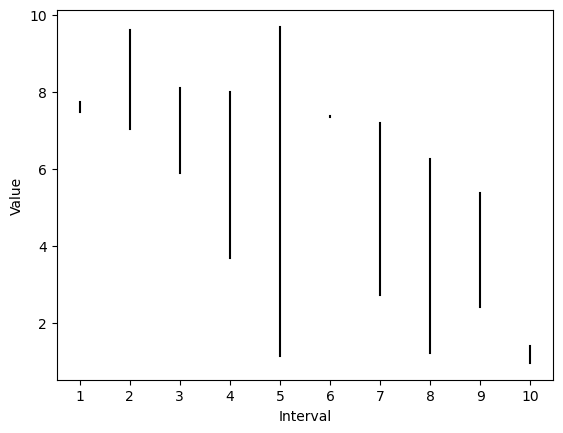

In [ ]:
intervals = [(1.23, 6.25), (5.89, 8.09), (1.15, 9.68), (2.41, 5.36), (7.34, 7.37), (7.48, 7.73), (7.02, 9.59), (0.96, 1.4), (3.68, 7.99), (2.72, 7.18)]

plot_intervals(sort_instance(intervals, 4))

In [ ]:
solve_instance(intervals, 4, lex_order_p=0)

([(8.2, 8.5),
  (5.63, 5.95),
  (5.32, 5.47),
  (4.58, 8.56),
  (0.87, 8.8),
  (2.3, 9.4),
  (2.76, 8.09),
  (2.42, 6.06)],
 3,
 [],
 [(0.03, 4.84), (1.13, 3.49)])

In [82]:
intervals = [(8.2, 8.5),
  (5.63, 5.95),
  (5.32, 5.47),
  (4.58, 8.56),
  (0.87, 8.8),
  (2.3, 9.4),
  (2.76, 8.09),
  (2.42, 6.06)]
k = 3
instance = sort_instance(intervals, k)
get_constraints(instance)

[(0, 1), (0, 5), (0, 6), (0, 7), (1, 7)]

In [ ]:
n = 10
iters = 1000
for k in range(2,5):
    for _ in range(iters):
        intervals = generate_instance(n)
        intervals = sort_instance(intervals, k)
        v_star, p_star, _ = solve_instance(intervals, k, lex_order_p=0)
        p_check = np.round(p_star, 3) # check up to 3 decimal places
        check = all(p_check[i] >= p_check[i+1] for i in range(n-1))
        if (not check):
            # check if exists optimal monotonic p_star
            v_star_mono, p_star_mono, _ = solve_instance(intervals, k, lex_order_p=0, force_monotone=True)
            if not np.isclose(v_star, v_star_mono):
                print("k:", k)
                print("intervals:", intervals)
                print("constraints:", get_constraints(intervals))
                print("p_star 1:", np.round(p_star, 3))
                break
    print('DONE with k:', k)

DONE with k: 2
k: 3
intervals: [(8.2, 8.5), (5.63, 5.95), (5.32, 5.47), (4.58, 8.56), (0.87, 8.8), (2.3, 9.4), (2.76, 8.09), (2.42, 6.06), (0.03, 4.84), (1.13, 3.49)]
constraints: [(0, 1), (0, 2), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 8), (1, 9), (2, 8), (2, 9), (3, 9)]
p_star 1: [1.    0.217 0.444 0.444 0.444 0.167 0.167 0.116 0.    0.   ]
DONE with k: 3
k: 4
intervals: [(5.53, 8.74), (6.35, 8.87), (2.69, 5.47), (0.22, 7.72), (0.93, 8.49), (1.08, 7.96), (1.75, 7.81), (1.44, 4.84), (1.93, 2.74), (1.3, 2.22)]
constraints: [(0, 2), (0, 7), (0, 8), (0, 9), (1, 2), (1, 7), (1, 8), (1, 9), (2, 9)]
p_star 1: [1.  1.  0.  0.5 0.5 0.5 0.5 0.  0.  0. ]
DONE with k: 4


In [ ]:
n = 10
k = 2

intervals = generate_instance(n)
intervals = sort_instance(intervals, k)

v_star, p_star, tight_constraints = solve_instance(intervals, k, lex_order_p=1)

In [41]:
np.round(p_star, 3)

array([0.5 , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.  , 0.  , 0.  ])

In [ ]:
# generate all perms of 7 elements within constraints
n = 10
perms = list(itertools.permutations(range(n)))
k = 4
# generate conditions: perm[i] <= k+1 for i < k and perm[i] >= k for i > k+1
perms = [perm for perm in perms if all([perm[i] <= k+1 for i in range(k-1)]) and all([perm[i] >= k for i in range(k+2, n)]) 
         and perm[k-1] <= k+3 and perm[k+2] >= k-1 and perm[k+3] >= k-1]
thetas = [1]*k + [0]*(n-k)

get_optimal_strategy(thetas, k, perms, return_tight_constraints=False)

(array(2.66666667),
 array([6.66666667e-01, 6.66666667e-01, 6.66666667e-01, 6.66666667e-01,
        6.66666667e-01, 6.66666667e-01, 1.78484220e-10, 1.77144763e-10,
        1.76478549e-10, 1.76146310e-10]),
 None)

In [27]:
def generate_minimal_permutations(n, k, D):
    # Assume k=1 for now
    if k != 1:
        raise ValueError("k must be 1")
    if n < 3*D:
        raise ValueError("n must be at least 3D")
    
    permutations = []
    # D+1 to 2D can be any vector of +D's and -D's 
    for v1 in itertools.product([-D, D], repeat=D):
        v1 = np.array(v1)
        v0 = np.zeros(D)
        I = np.where(v1 == -D)[0]
        if len(I) > 0:
            v0[I] = I + D
        J = np.where(v1 == D)[0]
        if len(J) > 0:
            v0[J] = J[::-1]
        v = np.concatenate((v0, np.arange(D,2*D) + v1))
        permutations.append(v.astype(int))
    return permutations

def get_optimal_strategy_pruned(thetas, n, k, D):
    if k != 1:
        raise ValueError("k must be 1")
    if n < 3*D:
        raise ValueError("n must be at least 3D")
    
    permutations = generate_minimal_permutations(n, k, D)
    theta_perms = [thetas[p] for p in permutations]
    theta_perms = list(set(map(tuple, theta_perms))) # dedupe 

    supp = 2*D + k - 1

    # Decision variables
    v = cp.Variable()
    p = cp.Variable(supp, nonneg=True)

    # Constraints: adversary's worst-case selection
    constraints = [v - cp.matmul(theta_p, p) <= 0 for theta_p in theta_perms]
    # Constraints: p sums to k
    constraints.append(cp.sum(p) == k)
    # Constraints: all p_i are in [0, 1]
    constraints += [p[i] <= 1 for i in range(supp)]
    # Constraints: p is monotone
    constraints += [p[i] >= p[i+1] for i in range(supp-1)]

    # Objective: maximize v
    objective = cp.Maximize(v)

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    v_opt = v.value
    p_opt = p.value

    if v_opt is None:
        return None, None, None
    tight_constraints = [theta_p for theta_p in theta_perms if np.isclose(v_opt - np.dot(theta_p, p_opt), 0)]

    return v_opt, p_opt, tight_constraints

In [28]:
n=10
k=1
D=3

thetas = n - np.arange(1,n+1)  # Borda count
v_opt, p_opt, tight_constraints = get_optimal_strategy_pruned(thetas, n, k, D)
print("Optimal value:", np.round(v_opt, 3))
print("Optimal strategy:", np.round(p_opt, 3))
print("Tight constraints:", tight_constraints)

Optimal value: 6.2
Optimal strategy: [0.4  0.16 0.16 0.16 0.08 0.04]
Tight constraints: [(7, 8, 9, 3, 2, 1), (6, 8, 4, 9, 2, 7), (6, 5, 4, 9, 8, 7), (8, 9, 4, 3, 2, 7), (7, 5, 9, 3, 8, 1)]


In [32]:
D_dict = get_all_linf_distances(10)

In [34]:
n=10
k=1
D=3

thetas = n - np.arange(1,n+1)  # Borda count
v_opt, p_opt, tight_constraints = get_optimal_strategy(thetas, k, generate_linf_permutations(n,D, D_dict),
                                                        return_tight_constraints=True, lex_order_p=0)
print("Optimal value:", np.round(v_opt, 3))
print("Optimal strategy:", np.round(p_opt, 3))
# print("Tight constraints:", tight_constraints)

Optimal value: 6.138
Optimal strategy: [0.377 0.189 0.151 0.126 0.094 0.063 0.    0.    0.    0.   ]


In [8]:
I = generate_instance(5000)
I, k, _, _ = prune_instance(I, 1000)

In [25]:
def order_instance(intervals):
    n = len(intervals)
    constraints = get_constraints(intervals)
    A = [0]*len(intervals)
    B = [0]*len(intervals)
    for c in constraints:
        A[c[1]] += 1 # num intevals that are strictly above i
        B[c[0]] += 1 # num intevals that are strictly below i
    # get all intervals with B[i] > 0
    top = [i for i in range(n) if B[i] > 0]
    # sort top by decreasing B (LCB) breaking ties with increasing A
    sorted_top = sorted(top, key=lambda i: (-B[i], A[i]))
    m_0 = len(top)
    # sort bottom by increasing A (UCB) 
    bottom = [i for i in range(n) if B[i] == 0]
    sorted_bottom = sorted(bottom, key=lambda i: A[i])  
    order = sorted_top + sorted_bottom
    A = [A[i] for i in order]
    B = [B[i] for i in order]
    I = [intervals[i] for i in order]
    return I, A, B, m_0

In [26]:
I, A, B, m_0 = order_instance(I)

In [27]:
import math 

def generate_constraints(I, A, B, k, m_0):
    n_constraints = 0
    n = len(I)
    for i in range(m_0):
        # include 0 to i-1
        c = list(range(i))
        # let S_i be the set of intervals in {i+1,...,m} that overlap i
        S_i = [j for j in range(m_0, len(I)) if I[j][0] < I[i][1]]
        t_i = len(S_i)
        # m_i is largest index in A that is <=i 
        m_i = max([j for j in range(n) if A[j] <= i])
        a_max = min(k - i, m_i - m_0)
        a_min = max(0, k - i - t_i)
        for a in range(a_min, a_max+1):
            # include (m_i - a + 1) to m_i
            c += [m_i - x for x in range(a)] 
            if a < a_max:
                A_min = A[m_i - a]
                # only consider elements of S_i with A[i] >= j
                S_i_a = [j for j in S_i if A[j] >= A_min]
            else: 
                S_i_a = S_i
                if len(S_i_a) < k-i-a:
                    continue
            
            # split S_i_a by values of A 
            S_i_a_dict = {}
            for j in S_i_a:
                if A[j] not in S_i_a_dict:
                    S_i_a_dict[A[j]] = []
                S_i_a_dict[A[j]].append(j)
            choices = [1+len(S_i_a_dict[j]) for j in S_i_a_dict]
            max_choices1 = np.prod(choices)
            # len(S_i_a) choose n_choose 
            max_choices2 = math.comb(len(S_i_a), k-i-a)  
            max_choices = min(max_choices1, max_choices2)
            n_constraints += max_choices
        return n_constraints


In [28]:
generate_constraints(I, A, B, k, m_0)

0

In [ ]:
### Difficult to prune instance ###
m0 = 10
k = m0+1
# Generate intervals 1 to m0/2 all overlapping but monotonically decreasing
intervals = [(m0-i, m0-(i/m0)) for i in range(1, m0//2+1)]
# Generate intervals m0/2+1 to m0 such that interval m0/2+j overlaps with interval (m0/2-j+1) but is strictly below (m0/2-j)
intervals += [(m0/2-j-m0/1000., m0/2+j-m0/1000.) for j in range(1, m0//2+1)]
# Intervals m0+1 to m0+1+k/2 all overlap interval 1
intervals += [(-1, intervals[0][1]) for k in range(0, k//2+1)]
# For j in 2 to k-1 generate an interval that overlaps with interval j but is strictly below j-1
intervals += [(-1, intervals[j][0]+m0/100.) for j in range(1, m0+1)]

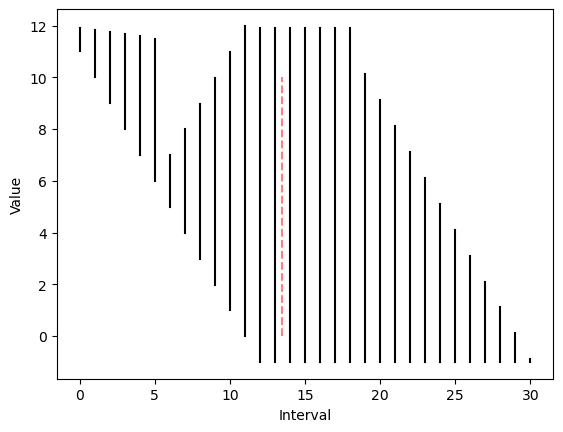

In [18]:
plot_intervals(intervals)

In [15]:
import time
from functools import lru_cache

def check_instance(A, B, m0, k):
    n = len(A)

    # check that intervals from 0 to (m0-1) are sorted by decreasing LCB and all have B[i] > 0
    assert all([B[i] > 0 for i in range(m0)])
    assert all([intervals[i][0] >= intervals[i+1][0] for i in range(m0-1)])
    # check that intervals from m0 to n-1 are sorted by increasing UCB and all have A[i] > 0
    assert all([B[i] == 0 for i in range(m0, n-1)])
    assert all([intervals[i][1] >= intervals[i+1][1] for i in range(m0, n-1)])
    # check that all intervals have A < k and B < n-k
    assert all([A[i] < k for i in range(n)])
    assert all([n - (A[i] + B[i] + 1) >= k for i in range(n)]) # i overlaps with at least k other intervals

def find_tuples(maxes, k, i):
    n = len(maxes)
    target = k - i
    
    @lru_cache(None)
    def dp(index, remaining):
        if remaining < 0:
            return []
        if index == n:
            return [[]] if remaining == 0 else []
        
        result = []
        for x in range(min(maxes[index], remaining) + 1):
            for suffix in dp(index + 1, remaining - x):
                result.append([x] + suffix)
        
        return result
    
    return dp(0, target)


# generate pruned problem instance
def solve_pruned(intervals, m0, k):
    print('Solving with n={}, k={}'.format(len(intervals), k))
    n = len(intervals)

    start_time = time.time()
    print('Computing A and B...')
    A = [0]*len(intervals)
    B = [0]*len(intervals)
    for c in get_constraints(intervals):
        A[c[1]] += 1 # num intervals that are strictly above i
        B[c[0]] += 1 # num intervals that are strictly below i
    print(f'Computing A and B... Done in {time.time() - start_time:.2f} seconds.')

    start_time = time.time()
    print('Verifying problem instance is pruned and sorted correctly...')
    check_instance(A, B, m0, k)
    print(f'Verifying problem instance is pruned and sorted correctly... Done in {time.time() - start_time:.2f} seconds.')

    start_time = time.time()
    print('Generating constraints...')
    # Decision variables
    v = cp.Variable()
    p = cp.Variable(n, nonneg=True)

    constraints = []
    # Constraints: p sums to k
    constraints.append(cp.sum(p) == k)
    # Constraints: all p_i are in [0, 1]
    constraints += [p[i] <= 1 for i in range(n)]

    ## Add monotonicity constraints
    # Constraints: p is monotone above m0
    constraints += [p[i] >= p[i+1] for i in range(m0, n-1)]
    # Constraints: p is monotone whenever A[i] <= A[j] and i < j
    for i in range(m0):
        for j in range(i+1, n):
            if A[i] <= A[j]:
                constraints.append(p[i] >= p[j])

    # Break the indices up into sets S_0,...,S_{m0} by value of A(x)
    S_dict = {}
    for i in range(n):
        if A[i] not in S_dict:
            S_dict[A[i]] = []
        S_dict[A[i]].append(i)
    # reverse order of each S_i
    for i in range(n):
        S_dict[A[i]] = S_dict[A[i]][::-1]
    # sort S_dict by decreasing value of keys (A)
    S_dict = dict(sorted(S_dict.items(), reverse=True))

    # Add adversary's worst case selection constraints
    for i in range(m0):
        print('Iteration: ', i)
        # Filter S_dict_i to only contain values > i
        S_dict = {A_val: [j for j in inds if j > i] for A_val, inds in S_dict.items()}
        # Get maximum value of each a_i based on size of S_dict_i
        maxes = [len(inds) for inds in S_dict.values()]
        # Get all possible (a_i,...,a_0) such that a_i <= maxes[i] and sum a_i = k - i
        a_vals = find_tuples(maxes, k, i)

        # Add constraints for each a_i,...,a_0
        for a in a_vals:
            constr = list(range(i)) + [S_dict[j][:a_j] for j, a_j in enumerate(a[::-1])]
            constr = [x for sublist in constr for x in (sublist if isinstance(sublist, list) else [sublist])]
            assert(len(constr) == k)
            constraints.append(v - cp.sum([p[i] for i in constr]) <= 0)
    print(f'Generating constraints... Done in {time.time() - start_time:.2f} seconds.')
    print(f'Generated {len(constraints)} constraints.')

    start_time = time.time()
    print('Solving problem...')
    # Objective: maximize v
    objective = cp.Maximize(v)

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
    print(f'Solving problem... Done in {time.time() - start_time:.2f} seconds.')

    return v.value, p.value

In [16]:
solve_pruned(intervals, m0, k)

Solving with n=31, k=13
Computing A and B...
Computing A and B... Done in 0.00 seconds.
Verifying problem instance is pruned and sorted correctly...
Verifying problem instance is pruned and sorted correctly... Done in 0.00 seconds.
Generating constraints...
Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Generating constraints... Done in 107.20 seconds.
Generated 166989 constraints.
Solving problem...
Solving problem... Done in 2448.57 seconds.


(array(5.4516129),
 array([0.41935484, 0.41935484, 0.41935484, 0.41935484, 0.41935484,
        0.41935484, 0.41935484, 0.41935484, 0.41935484, 0.41935484,
        0.41935484, 0.41935484, 0.41935484, 0.41935484, 0.41935484,
        0.41935484, 0.41935484, 0.41935484, 0.41935484, 0.41935484,
        0.41935484, 0.41935484, 0.41935484, 0.41935484, 0.41935484,
        0.41935484, 0.41935484, 0.41935484, 0.41935484, 0.41935484,
        0.41935484]))